# 25. カテゴリカル変数の高度な処理 (Advanced Categorical Variable Encoding)

## 概要
カテゴリカル変数を効果的に数値化するための高度な手法を学びます。Target Encoding、Frequency Encoding、Embeddingなど、実務で差がつくテクニックを網羅します。

## 学習目標
- カテゴリカル変数の種類を理解できる
- 基本的なエンコーディング手法を使える
- Target Encodingを正しく実装できる
- 高カーディナリティ変数を扱える
- Embeddingの概念を理解できる
- 実務でのベストプラクティスを適用できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from category_encoders import TargetEncoder, LeaveOneOutEncoder, WOEEncoder, CatBoostEncoder
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


## 1. カテゴリカル変数とは

### カテゴリカル変数の定義

**カテゴリカル変数（Categorical Variable）**は、有限個の値（カテゴリ）を取る変数です。

### カテゴリカル変数の種類

1. **名義変数（Nominal）**
   - 順序関係がない
   - 例: 色（赤、青、緑）、都市名、商品カテゴリ

2. **順序変数（Ordinal）**
   - 順序関係がある
   - 例: 教育レベル（小学校 < 中学校 < 高校 < 大学）、サイズ（S < M < L < XL）

3. **二値変数（Binary）**
   - 2つの値のみ
   - 例: 性別（男/女）、Yes/No

### なぜエンコーディングが必要か

多くの機械学習アルゴリズムは**数値データ**しか扱えません。

- ✅ ツリーベースモデル（Random Forest、XGBoostなど）: カテゴリを直接扱える場合もある
- ❌ 線形モデル（Logistic Regression、SVMなど）: 数値化が必須

### 実世界での例

- 🏠 **不動産**: 地域、建物タイプ
- 🛒 **Eコマース**: 商品カテゴリ、ブランド
- 💳 **金融**: 職業、都道府県
- 🏥 **医療**: 診断名、治療法

## 2. サンプルデータの準備

In [2]:
# サンプルデータの生成（住宅ローン承認予測）
np.random.seed(42)
n_samples = 5000

# カテゴリカル変数
cities = ['Tokyo', 'Osaka', 'Nagoya', 'Fukuoka', 'Sapporo', 'Sendai', 'Hiroshima', 'Kyoto']
occupations = ['Engineer', 'Doctor', 'Teacher', 'Sales', 'Manager', 'Student', 'Self-employed', 
               'Artist', 'Unemployed', 'Retired']
education = ['High School', 'Bachelor', 'Master', 'PhD']
property_type = ['Apartment', 'House', 'Condo', 'Townhouse']
marital_status = ['Single', 'Married', 'Divorced', 'Widowed']

# データ生成
data = {
    'city': np.random.choice(cities, n_samples),
    'occupation': np.random.choice(occupations, n_samples),
    'education': np.random.choice(education, n_samples),
    'property_type': np.random.choice(property_type, n_samples),
    'marital_status': np.random.choice(marital_status, n_samples),
    'age': np.random.randint(22, 70, n_samples),
    'income': np.random.lognormal(13, 0.5, n_samples),  # 年収（万円）
    'loan_amount': np.random.lognormal(15, 0.4, n_samples)  # ローン額（万円）
}

df = pd.DataFrame(data)

# ターゲット変数（承認/却下）の生成
# 収入が高い、教育レベルが高い、特定の職業などで承認されやすい
approval_score = (
    (df['income'] / df['income'].mean()) * 0.3 +
    (df['education'].map({'High School': 0.5, 'Bachelor': 0.7, 'Master': 0.85, 'PhD': 1.0})) * 0.25 +
    (df['occupation'].map({
        'Doctor': 1.0, 'Engineer': 0.9, 'Manager': 0.85, 'Teacher': 0.75,
        'Sales': 0.6, 'Self-employed': 0.55, 'Artist': 0.5, 
        'Student': 0.3, 'Unemployed': 0.1, 'Retired': 0.4
    })) * 0.25 +
    (1 - df['loan_amount'] / df['income']) * 0.2 +
    np.random.normal(0, 0.1, n_samples)
)

df['approved'] = (approval_score > approval_score.median()).astype(int)

print(f"データサイズ: {df.shape}")
print(f"\nカテゴリカル変数の数: {df.select_dtypes(include='object').shape[1]}")
print(f"数値変数の数: {df.select_dtypes(include=['int64', 'float64']).shape[1] - 1}")
print(f"\nターゲット分布:")
print(df['approved'].value_counts())
print(f"\nデータの先頭:")
print(df.head(10))

データサイズ: (5000, 9)

カテゴリカル変数の数: 5
数値変数の数: 3

ターゲット分布:
approved
1    2500
0    2500
Name: count, dtype: int64

データの先頭:
        city     occupation    education property_type marital_status  age  \
0  Hiroshima        Teacher  High School     Townhouse        Widowed   25   
1    Fukuoka          Sales          PhD     Apartment        Married   26   
2    Sapporo  Self-employed          PhD     Apartment         Single   47   
3  Hiroshima        Teacher       Master     Apartment       Divorced   46   
4     Nagoya     Unemployed  High School     Apartment         Single   31   
5      Kyoto         Artist       Master     Townhouse        Married   29   
6    Sapporo          Sales       Master     Apartment        Married   33   
7    Sapporo       Engineer     Bachelor     Townhouse        Married   24   
8  Hiroshima       Engineer  High School         House        Widowed   48   
9      Osaka       Engineer  High School     Townhouse         Single   44   

         income   loan_a

In [3]:
# カテゴリカル変数の詳細
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("カテゴリカル変数の詳細:")
print("=" * 60)

for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"\n{col}:")
    print(f"  ユニーク値数: {n_unique}")
    print(f"  値: {df[col].unique()[:10].tolist()}")
    
    # カーディナリティ（ユニーク値数）に基づく分類
    if n_unique == 2:
        cardinality = "低（Binary）"
    elif n_unique <= 5:
        cardinality = "低"
    elif n_unique <= 10:
        cardinality = "中"
    else:
        cardinality = "高"
    
    print(f"  カーディナリティ: {cardinality}")

カテゴリカル変数の詳細:

city:
  ユニーク値数: 8
  値: ['Hiroshima', 'Fukuoka', 'Sapporo', 'Nagoya', 'Kyoto', 'Osaka', 'Sendai', 'Tokyo']
  カーディナリティ: 中

occupation:
  ユニーク値数: 10
  値: ['Teacher', 'Sales', 'Self-employed', 'Unemployed', 'Artist', 'Engineer', 'Student', 'Manager', 'Doctor', 'Retired']
  カーディナリティ: 中

education:
  ユニーク値数: 4
  値: ['High School', 'PhD', 'Master', 'Bachelor']
  カーディナリティ: 低

property_type:
  ユニーク値数: 4
  値: ['Townhouse', 'Apartment', 'House', 'Condo']
  カーディナリティ: 低

marital_status:
  ユニーク値数: 4
  値: ['Widowed', 'Married', 'Single', 'Divorced']
  カーディナリティ: 低


## 3. 基本的なエンコーディング手法

### 3.1 Label Encoding

各カテゴリに整数を割り当てます。

- ✅ **適用場面**: 順序変数
- ❌ **注意**: 名義変数に使うと誤った順序関係を学習する可能性

In [4]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

df_label = df.copy()

# 教育レベル（順序変数）
education_order = {'High School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}
df_label['education_label'] = df_label['education'].map(education_order)

print("Label Encoding（教育レベル）:")
print(df_label[['education', 'education_label']].drop_duplicates().sort_values('education_label'))

print("\n💡 ポイント:")
print("- 順序変数には適切（High School < Bachelor < Master < PhD）")
print("- 名義変数には不適切（都市名などに順序関係はない）")

Label Encoding（教育レベル）:
     education  education_label
0  High School                0
7     Bachelor                1
3       Master                2
1          PhD                3

💡 ポイント:
- 順序変数には適切（High School < Bachelor < Master < PhD）
- 名義変数には不適切（都市名などに順序関係はない）


### 3.2 One-Hot Encoding

各カテゴリを二値変数（ダミー変数）に変換します。

- ✅ **適用場面**: 低カーディナリティの名義変数
- ❌ **注意**: 高カーディナリティだと次元爆発

In [5]:
# One-Hot Encoding
df_onehot = df.copy()

# property_type（4カテゴリ）をOne-Hot Encoding
onehot_encoded = pd.get_dummies(df_onehot['property_type'], prefix='property')
df_onehot = pd.concat([df_onehot, onehot_encoded], axis=1)

print("One-Hot Encoding（物件タイプ）:")
print(df_onehot[['property_type'] + onehot_encoded.columns.tolist()].head(10))

print(f"\n元の列数: 1")
print(f"One-Hot後の列数: {len(onehot_encoded.columns)}")

print("\n💡 ポイント:")
print("- 各カテゴリが独立した列になる")
print("- 線形モデルに最適")
print("- カーディナリティが高いと列数が爆発的に増える")

One-Hot Encoding（物件タイプ）:
  property_type  property_Apartment  property_Condo  property_House  \
0     Townhouse               False           False           False   
1     Apartment                True           False           False   
2     Apartment                True           False           False   
3     Apartment                True           False           False   
4     Apartment                True           False           False   
5     Townhouse               False           False           False   
6     Apartment                True           False           False   
7     Townhouse               False           False           False   
8         House               False           False            True   
9     Townhouse               False           False           False   

   property_Townhouse  
0                True  
1               False  
2               False  
3               False  
4               False  
5                True  
6               False  
7

In [6]:
# 高カーディナリティ変数でのOne-Hot Encodingの問題
print("高カーディナリティ変数の例（occupation: 10カテゴリ）:")
occupation_onehot = pd.get_dummies(df['occupation'], prefix='occ')
print(f"列数: {len(occupation_onehot.columns)}")
print(f"\nカーディナリティが100なら → 100列")
print(f"カーディナリティが1000なら → 1000列（次元の呪い）")

print("\n⚠️ 問題点:")
print("- メモリ使用量の増大")
print("- 学習時間の増加")
print("- 過学習のリスク")
print("- スパース（疎）な特徴量行列")

高カーディナリティ変数の例（occupation: 10カテゴリ）:
列数: 10

カーディナリティが100なら → 100列
カーディナリティが1000なら → 1000列（次元の呪い）

⚠️ 問題点:
- メモリ使用量の増大
- 学習時間の増加
- 過学習のリスク
- スパース（疎）な特徴量行列


## 4. 高度なエンコーディング手法

### 4.1 Frequency Encoding（頻度エンコーディング）

各カテゴリの出現頻度を値として使います。

In [7]:
# Frequency Encoding
def frequency_encoding(df, column):
    """
    頻度エンコーディング
    
    Parameters:
    -----------
    df : DataFrame
    column : str
        対象のカラム名
    
    Returns:
    --------
    encoded : Series
        エンコード済みの系列
    """
    freq = df[column].value_counts(normalize=True)
    return df[column].map(freq)

df_freq = df.copy()
df_freq['city_freq'] = frequency_encoding(df_freq, 'city')
df_freq['occupation_freq'] = frequency_encoding(df_freq, 'occupation')

print("Frequency Encoding:")
print(df_freq[['city', 'city_freq', 'occupation', 'occupation_freq']].head(10))

# 頻度の分布
city_freq_summary = df_freq.groupby('city')['city_freq'].first().sort_values(ascending=False)
print("\n都市別の頻度:")
print(city_freq_summary)

print("\n💡 メリット:")
print("- 単一の列で表現（次元増加なし）")
print("- 高カーディナリティでも使える")
print("- 実装が簡単")

print("\n⚠️ デメリット:")
print("- 異なるカテゴリが同じ値になる可能性")
print("- カテゴリの意味を失う")

Frequency Encoding:
        city  city_freq     occupation  occupation_freq
0  Hiroshima     0.1202        Teacher           0.0966
1    Fukuoka     0.1314          Sales           0.0966
2    Sapporo     0.1302  Self-employed           0.1064
3  Hiroshima     0.1202        Teacher           0.0966
4     Nagoya     0.1216     Unemployed           0.0962
5      Kyoto     0.1198         Artist           0.0970
6    Sapporo     0.1302          Sales           0.0966
7    Sapporo     0.1302       Engineer           0.0986
8  Hiroshima     0.1202       Engineer           0.0986
9      Osaka     0.1224       Engineer           0.0986

都市別の頻度:
city
Fukuoka      0.1314
Sapporo      0.1302
Tokyo        0.1288
Sendai       0.1256
Osaka        0.1224
Nagoya       0.1216
Hiroshima    0.1202
Kyoto        0.1198
Name: city_freq, dtype: float64

💡 メリット:
- 単一の列で表現（次元増加なし）
- 高カーディナリティでも使える
- 実装が簡単

⚠️ デメリット:
- 異なるカテゴリが同じ値になる可能性
- カテゴリの意味を失う


### 4.2 Target Encoding（ターゲットエンコーディング）

各カテゴリにおけるターゲット変数の平均値を使います。

**⚠️ 重要**: データリークを防ぐため、**Out-of-Fold (OOF)** で計算する必要があります。

In [8]:
# ナイーブなTarget Encoding（データリークあり - 悪い例）
def naive_target_encoding(df, column, target):
    """
    ナイーブなTarget Encoding（教育目的のみ！実務では使用禁止）
    """
    target_mean = df.groupby(column)[target].mean()
    return df[column].map(target_mean)

df_target_naive = df.copy()
df_target_naive['occupation_target_naive'] = naive_target_encoding(
    df_target_naive, 'occupation', 'approved'
)

print("ナイーブなTarget Encoding（職業）:")
occupation_target = df_target_naive.groupby('occupation').agg({
    'approved': 'mean',
    'occupation_target_naive': 'first'
}).sort_values('approved', ascending=False)
print(occupation_target)

print("\n⚠️ 警告:")
print("- このコードは教育目的の悪い例です")
print("- テストデータの情報が訓練データに漏れる（データリーク）")
print("- 過学習を引き起こす")
print("- 実務では絶対に使用禁止！")

ナイーブなTarget Encoding（職業）:
               approved  occupation_target_naive
occupation                                      
Teacher        0.525880                 0.525880
Sales          0.523810                 0.523810
Doctor         0.519685                 0.519685
Manager        0.512766                 0.512766
Engineer       0.503043                 0.503043
Retired        0.492481                 0.492481
Self-employed  0.488722                 0.488722
Artist         0.488660                 0.488660
Unemployed     0.476091                 0.476091
Student        0.472795                 0.472795

⚠️ 警告:
- このコードは教育目的の悪い例です
- テストデータの情報が訓練データに漏れる（データリーク）
- 過学習を引き起こす
- 実務では絶対に使用禁止！


In [9]:
# 正しいTarget Encoding（Out-of-Fold方式）
from category_encoders import TargetEncoder

# データ分割
X = df[categorical_cols + ['age', 'income', 'loan_amount']]
y = df['approved']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Target Encoder（category_encodersライブラリ）
target_encoder = TargetEncoder(cols=categorical_cols, smoothing=1.0)

# 訓練データでfitして変換
X_train_encoded = target_encoder.fit_transform(X_train, y_train)

# テストデータは訓練データの統計量で変換
X_test_encoded = target_encoder.transform(X_test)

print("正しいTarget Encoding:")
print("\n訓練データ（エンコード後）:")
print(X_train_encoded.head(10))

print("\n💡 重要なポイント:")
print("- fit()は訓練データのみで行う")
print("- テストデータにはtransform()のみ適用")
print("- これによりデータリークを防ぐ")
print("- クロスバリデーション時も各Foldで個別にfit")

正しいTarget Encoding:

訓練データ（エンコード後）:
          city  occupation  education  property_type  marital_status  age  \
2872  0.489443    0.517588   0.467925       0.493827        0.516650   40   
642   0.527083    0.489559   0.535000       0.501949        0.516650   59   
1182  0.527083    0.489559   0.535000       0.501949        0.510978   62   
3212  0.471545    0.502392   0.505353       0.507782        0.473013   41   
3909  0.498092    0.477089   0.505353       0.495893        0.516650   57   
1316  0.471545    0.520436   0.505353       0.507782        0.510978   40   
4751  0.498092    0.520619   0.494036       0.501949        0.516650   43   
2071  0.501044    0.489559   0.467925       0.493827        0.500000   44   
1010  0.489443    0.477435   0.494036       0.493827        0.473013   52   
2684  0.512195    0.503563   0.505353       0.507782        0.473013   26   

             income   loan_amount  
2872  495300.989829  2.164444e+06  
642   367597.298973  1.792336e+06  
1182  63

In [10]:
# Smoothingパラメータの効果
print("Target Encodingのスムージング:")
print("=" * 60)

# 職業別の統計
occupation_stats = df.groupby('occupation').agg({
    'approved': ['mean', 'count']
}).round(4)
occupation_stats.columns = ['approval_rate', 'count']
occupation_stats = occupation_stats.sort_values('count')

print(occupation_stats)

print("\n💡 スムージングの必要性:")
print("- サンプル数が少ないカテゴリは信頼性が低い")
print("- スムージングで全体平均に近づける")
print("- 過学習を防ぐ効果")
print("\n式: (count * mean + smoothing * global_mean) / (count + smoothing)")

Target Encodingのスムージング:
               approval_rate  count
occupation                         
Manager               0.5128    470
Unemployed            0.4761    481
Teacher               0.5259    483
Sales                 0.5238    483
Artist                0.4887    485
Engineer              0.5030    493
Doctor                0.5197    508
Retired               0.4925    532
Self-employed         0.4887    532
Student               0.4728    533

💡 スムージングの必要性:
- サンプル数が少ないカテゴリは信頼性が低い
- スムージングで全体平均に近づける
- 過学習を防ぐ効果

式: (count * mean + smoothing * global_mean) / (count + smoothing)


### 4.3 CatBoost Encoding

CatBoostアルゴリズムで使われる、より洗練されたTarget Encodingです。

In [11]:
# CatBoost Encoding
from category_encoders import CatBoostEncoder

catboost_encoder = CatBoostEncoder(cols=categorical_cols)

X_train_catboost = catboost_encoder.fit_transform(X_train, y_train)
X_test_catboost = catboost_encoder.transform(X_test)

print("CatBoost Encoding:")
print("\n訓練データ（エンコード後）:")
print(X_train_catboost.head(10))

print("\n💡 CatBoost Encodingの特徴:")
print("- Target Encodingの改良版")
print("- より洗練された順序依存エンコーディング")
print("- CatBoostモデルと相性が良い")
print("- データリークを最小化")

CatBoost Encoding:

訓練データ（エンコード後）:
      city  occupation  education  property_type  marital_status  age  \
2872  0.50    0.500000   0.500000       0.500000        0.500000   40   
642   0.50    0.500000   0.500000       0.500000        0.750000   59   
1182  0.75    0.750000   0.750000       0.750000        0.500000   62   
3212  0.50    0.500000   0.500000       0.500000        0.500000   41   
3909  0.50    0.500000   0.250000       0.500000        0.833333   57   
1316  0.25    0.500000   0.166667       0.250000        0.750000   40   
4751  0.25    0.500000   0.500000       0.833333        0.625000   43   
2071  0.50    0.833333   0.750000       0.750000        0.500000   44   
1010  0.75    0.500000   0.250000       0.500000        0.250000   52   
2684  0.50    0.500000   0.375000       0.500000        0.166667   26   

             income   loan_amount  
2872  495300.989829  2.164444e+06  
642   367597.298973  1.792336e+06  
1182  639115.444832  8.611663e+05  
3212  301721.4107

### 4.4 Weight of Evidence (WoE) Encoding

**WoE Encoding**は、ロジスティック回帰のログオッズ比に基づくエンコーディングです。

In [12]:
# WoE Encoding
from category_encoders import WOEEncoder

woe_encoder = WOEEncoder(cols=categorical_cols)

X_train_woe = woe_encoder.fit_transform(X_train, y_train)
X_test_woe = woe_encoder.transform(X_test)

print("WoE Encoding:")
print("\n訓練データ（エンコード後）:")
print(X_train_woe.head(10))

# 職業別のWoE値
occupation_woe = X_train_woe.groupby(X_train['occupation'])['occupation'].first().sort_values()
print("\n職業別のWoE値:")
print(occupation_woe)

print("\n💡 WoEの解釈:")
print("- 正の値: 承認されやすいカテゴリ")
print("- 負の値: 却下されやすいカテゴリ")
print("- 0に近い: 全体平均と同程度")
print("\n式: ln(P(approved|category) / P(rejected|category))")

WoE Encoding:

訓練データ（エンコード後）:
          city  occupation  education  property_type  marital_status  age  \
2872 -0.042071    0.070029  -0.128236      -0.024642        0.066490   40   
642   0.107989   -0.041576   0.139949       0.007782        0.066490   59   
1182  0.107989   -0.041576   0.139949       0.007782        0.043832   62   
3212 -0.113482    0.009524   0.021368       0.031070       -0.107842   41   
3909 -0.007605   -0.091216   0.021368      -0.016394        0.066490   57   
1316 -0.113482    0.081346   0.021368       0.031070        0.043832   40   
4751 -0.007605    0.082097  -0.023811       0.007782        0.066490   43   
2071  0.004158   -0.041576  -0.128236      -0.024642        0.000000   44   
1010 -0.042071   -0.089895  -0.023811      -0.024642       -0.107842   52   
2684  0.048593    0.014185   0.021368       0.031070       -0.107842   26   

             income   loan_amount  
2872  495300.989829  2.164444e+06  
642   367597.298973  1.792336e+06  
1182  639115.4


職業別のWoE値:
occupation
Unemployed      -0.091216
Student         -0.089895
Artist          -0.055994
Self-employed   -0.041576
Retired          0.009524
Engineer         0.014185
Sales            0.030305
Doctor           0.070029
Manager          0.081346
Teacher          0.082097
Name: occupation, dtype: float64

💡 WoEの解釈:
- 正の値: 承認されやすいカテゴリ
- 負の値: 却下されやすいカテゴリ
- 0に近い: 全体平均と同程度

式: ln(P(approved|category) / P(rejected|category))


## 5. 高カーディナリティ変数の扱い

### カーディナリティの削減

高カーディナリティ変数（ユニーク値が多い）は、以下の方法で扱います。

In [13]:
# 高カーディナリティ変数のシミュレーション（都道府県）
np.random.seed(42)
prefectures = [f'Prefecture_{i:02d}' for i in range(1, 48)]  # 47都道府県

# Zipf分布（一部の都道府県に人口集中）
zipf_probs = 1.0 / np.arange(1, 48)
zipf_probs = zipf_probs / zipf_probs.sum()

df_high_card = df.copy()
df_high_card['prefecture'] = np.random.choice(prefectures, n_samples, p=zipf_probs)

print(f"都道府県のユニーク数: {df_high_card['prefecture'].nunique()}")
print("\n上位10都道府県の頻度:")
print(df_high_card['prefecture'].value_counts().head(10))
print("\n下位10都道府県の頻度:")
print(df_high_card['prefecture'].value_counts().tail(10))

都道府県のユニーク数: 47

上位10都道府県の頻度:
prefecture
Prefecture_01    1149
Prefecture_02     553
Prefecture_03     398
Prefecture_04     266
Prefecture_05     212
Prefecture_06     178
Prefecture_07     160
Prefecture_08     147
Prefecture_09     140
Prefecture_11     123
Name: count, dtype: int64

下位10都道府県の頻度:
prefecture
Prefecture_33    31
Prefecture_31    28
Prefecture_40    28
Prefecture_42    27
Prefecture_44    26
Prefecture_47    24
Prefecture_46    23
Prefecture_45    23
Prefecture_43    23
Prefecture_34    19
Name: count, dtype: int64


In [14]:
# 方法1: 頻度の低いカテゴリをまとめる
def group_rare_categories(df, column, threshold=0.01, rare_label='Other'):
    """
    頻度の低いカテゴリを'Other'にまとめる
    
    Parameters:
    -----------
    threshold : float
        この割合以下のカテゴリをまとめる
    """
    freq = df[column].value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index
    
    df_new = df.copy()
    df_new[column] = df_new[column].apply(
        lambda x: rare_label if x in rare_categories else x
    )
    
    return df_new, rare_categories

df_grouped, rare_prefs = group_rare_categories(df_high_card, 'prefecture', threshold=0.01)

print(f"元のユニーク数: {df_high_card['prefecture'].nunique()}")
print(f"グループ化後のユニーク数: {df_grouped['prefecture'].nunique()}")
print(f"'Other'にまとめられたカテゴリ数: {len(rare_prefs)}")
print(f"\nグループ化後の分布:")
print(df_grouped['prefecture'].value_counts().head(10))

元のユニーク数: 47
グループ化後のユニーク数: 23
'Other'にまとめられたカテゴリ数: 25

グループ化後の分布:
prefecture
Prefecture_01    1149
Other             814
Prefecture_02     553
Prefecture_03     398
Prefecture_04     266
Prefecture_05     212
Prefecture_06     178
Prefecture_07     160
Prefecture_08     147
Prefecture_09     140
Name: count, dtype: int64


In [15]:
# 方法2: Target Encoding（高カーディナリティに強い）
# すでに実装済み - Target Encodingは高カーディナリティでも有効

# 方法3: Frequency Encoding
df_high_card['prefecture_freq'] = frequency_encoding(df_high_card, 'prefecture')

print("高カーディナリティ変数の対策手法:")
print("=" * 60)
print("\n1. 低頻度カテゴリをまとめる")
print("   - メリット: カテゴリ数削減")
print("   - デメリット: 情報の損失")

print("\n2. Target Encoding")
print("   - メリット: 高カーディナリティでも単一列")
print("   - デメリット: データリークのリスク")

print("\n3. Frequency Encoding")
print("   - メリット: シンプル、高速")
print("   - デメリット: カテゴリの意味を失う")

print("\n4. Embedding（ディープラーニング）")
print("   - メリット: 複雑な関係性を学習")
print("   - デメリット: 学習コスト高")

高カーディナリティ変数の対策手法:

1. 低頻度カテゴリをまとめる
   - メリット: カテゴリ数削減
   - デメリット: 情報の損失

2. Target Encoding
   - メリット: 高カーディナリティでも単一列
   - デメリット: データリークのリスク

3. Frequency Encoding
   - メリット: シンプル、高速
   - デメリット: カテゴリの意味を失う

4. Embedding（ディープラーニング）
   - メリット: 複雑な関係性を学習
   - デメリット: 学習コスト高


## 6. エンコーディング手法の比較

In [16]:
# 複数のエンコーディング手法でモデル性能を比較
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# 数値変数のみ抽出
numeric_cols = ['age', 'income', 'loan_amount']

results = []

# 1. Label Encoding（教育レベルのみ）
X_label = X.copy()
X_label['education'] = X_label['education'].map(education_order)
for col in categorical_cols:
    if col != 'education':
        le = LabelEncoder()
        X_label[col] = le.fit_transform(X_label[col])

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label, y, test_size=0.2, random_state=42, stratify=y
)

rf_label = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_label.fit(X_train_label, y_train_label)
pred_label = rf_label.predict_proba(X_test_label)[:, 1]

results.append({
    'Encoding': 'Label Encoding',
    'Accuracy': accuracy_score(y_test_label, rf_label.predict(X_test_label)),
    'ROC-AUC': roc_auc_score(y_test_label, pred_label)
})

# 2. One-Hot Encoding
X_onehot = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(
    X_onehot, y, test_size=0.2, random_state=42, stratify=y
)

rf_onehot = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_onehot.fit(X_train_onehot, y_train_onehot)
pred_onehot = rf_onehot.predict_proba(X_test_onehot)[:, 1]

results.append({
    'Encoding': 'One-Hot Encoding',
    'Accuracy': accuracy_score(y_test_onehot, rf_onehot.predict(X_test_onehot)),
    'ROC-AUC': roc_auc_score(y_test_onehot, pred_onehot)
})

# 3. Target Encoding
rf_target = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_target.fit(X_train_encoded, y_train)
pred_target = rf_target.predict_proba(X_test_encoded)[:, 1]

results.append({
    'Encoding': 'Target Encoding',
    'Accuracy': accuracy_score(y_test, rf_target.predict(X_test_encoded)),
    'ROC-AUC': roc_auc_score(y_test, pred_target)
})

# 4. CatBoost Encoding
rf_catboost = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_catboost.fit(X_train_catboost, y_train)
pred_catboost = rf_catboost.predict_proba(X_test_catboost)[:, 1]

results.append({
    'Encoding': 'CatBoost Encoding',
    'Accuracy': accuracy_score(y_test, rf_catboost.predict(X_test_catboost)),
    'ROC-AUC': roc_auc_score(y_test, pred_catboost)
})

# 5. WoE Encoding
rf_woe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_woe.fit(X_train_woe, y_train)
pred_woe = rf_woe.predict_proba(X_test_woe)[:, 1]

results.append({
    'Encoding': 'WoE Encoding',
    'Accuracy': accuracy_score(y_test, rf_woe.predict(X_test_woe)),
    'ROC-AUC': roc_auc_score(y_test, pred_woe)
})

# 結果の表示
results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 70)
print("エンコーディング手法の性能比較（Random Forest）")
print("=" * 70)
print(results_df.to_string(index=False))

# ベスト手法
best_idx = results_df['ROC-AUC'].idxmax()
print(f"\n🏆 ベスト手法: {results_df.loc[best_idx, 'Encoding']}")
print(f"   ROC-AUC: {results_df.loc[best_idx, 'ROC-AUC']:.4f}")


エンコーディング手法の性能比較（Random Forest）
         Encoding  Accuracy  ROC-AUC
   Label Encoding     0.972 0.996502
CatBoost Encoding     0.966 0.995828
  Target Encoding     0.968 0.995724
     WoE Encoding     0.968 0.995724
 One-Hot Encoding     0.971 0.995512

🏆 ベスト手法: Label Encoding
   ROC-AUC: 0.9965


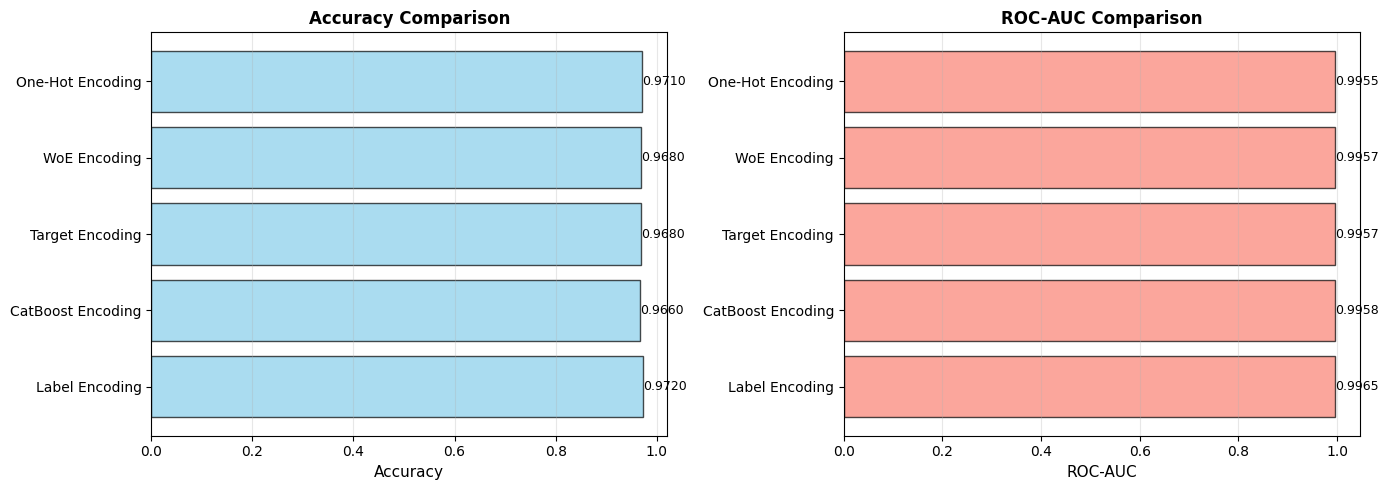

In [17]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].barh(results_df['Encoding'], results_df['Accuracy'], 
             alpha=0.7, edgecolor='black', color='skyblue')
axes[0].set_xlabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[0].text(row['Accuracy'], i, f"{row['Accuracy']:.4f}", 
                va='center', ha='left', fontsize=9)

# ROC-AUC
axes[1].barh(results_df['Encoding'], results_df['ROC-AUC'], 
             alpha=0.7, edgecolor='black', color='salmon')
axes[1].set_xlabel('ROC-AUC', fontsize=11)
axes[1].set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[1].text(row['ROC-AUC'], i, f"{row['ROC-AUC']:.4f}", 
                va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

## 7. 実務でのベストプラクティス

### エンコーディング手法の選択ガイド

| 状況 | 推奨手法 | 理由 |
|------|---------|------|
| 低カーディナリティ（<10） | One-Hot Encoding | シンプルで効果的 |
| 中カーディナリティ（10-50） | Target Encoding / WoE | 次元を抑えつつ効果的 |
| 高カーディナリティ（>50） | Target/CatBoost Encoding | 次元爆発を回避 |
| 順序変数 | Ordinal Encoding | 順序情報を保持 |
| ツリーベースモデル | Label/Target Encoding | 高速、効果的 |
| 線形モデル | One-Hot / WoE | 線形分離可能に |
| ディープラーニング | Embedding | 複雑な関係性を学習 |

### チェックリスト

```python
# ✅ カテゴリカル変数エンコーディング チェックリスト

# 1. データの確認
# - カテゴリカル変数を特定したか？
# - カーディナリティを確認したか？
# - 欠損値はあるか？
# - 順序関係はあるか？

# 2. エンコーディング手法の選択
# - カーディナリティに応じた手法を選んだか？
# - モデルに応じた手法を選んだか？
# - 複数の手法を試したか？

# 3. データリークの防止
# - Target Encodingでfit/transformを分けたか？
# - テストデータで訓練データの統計を使っているか？
# - クロスバリデーションで各Foldごとにfitしたか？

# 4. 高カーディナリティ対策
# - 低頻度カテゴリをまとめたか？
# - Target Encodingを検討したか？
# - Embeddingを検討したか？

# 5. 検証
# - エンコーディング前後で性能を比較したか？
# - 過学習していないか確認したか？
# - 特徴量重要度を確認したか？
```

### よくある落とし穴

1. **データリーク**: Target Encodingでテストデータの情報を使う
2. **次元の呪い**: 高カーディナリティでOne-Hot Encoding
3. **順序の無視**: 順序変数にLabel Encodingを使わない
4. **過学習**: スムージングなしのTarget Encoding
5. **欠損値の放置**: エンコーディング前に処理すべき

## 8. まとめ

### 本ノートブックで学んだこと

1. **カテゴリカル変数の基礎**
   - 名義変数、順序変数、二値変数
   - カーディナリティの概念
   - エンコーディングの必要性

2. **基本的なエンコーディング**
   - Label Encoding: 順序変数向け
   - One-Hot Encoding: 低カーディナリティ向け
   - Ordinal Encoding: 順序を保持

3. **高度なエンコーディング**
   - Frequency Encoding: シンプルで高速
   - Target Encoding: 高カーディナリティに強い
   - CatBoost Encoding: Target Encodingの改良版
   - WoE Encoding: ロジスティック回帰向け

4. **高カーディナリティ対策**
   - 低頻度カテゴリのグループ化
   - Target Encoding
   - Frequency Encoding
   - Embedding（ディープラーニング）

5. **データリークの防止**
   - Out-of-Fold Target Encoding
   - fit/transformの分離
   - クロスバリデーションでの注意

6. **実務での適用**
   - 状況別の手法選択
   - モデル性能の比較
   - ベストプラクティス

### 重要なポイント

- ✅ **カーディナリティで選ぶ**: 低ならOne-Hot、高ならTarget Encoding
- ✅ **データリーク厳禁**: Target Encodingはfit/transformを分離
- ✅ **順序を考慮**: 順序変数は適切に扱う
- ✅ **複数試す**: 1つの手法に固執しない
- ✅ **過学習注意**: スムージングやクロスバリデーションを活用
- ✅ **モデルとの相性**: ツリーと線形モデルで最適手法が異なる

### 次のステップ

- Phase 8完了！Phase 9（Kaggle実践コース）へ進む
- 実際のKaggleコンペでカテゴリカル変数を活用
- Embeddingを使ったディープラーニングモデルを学ぶ
- より高度な特徴量エンジニアリング手法を探求